In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


In [ ]:
print(torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())

In [ ]:
# ─── Cell 1: Compute & Save Per-Article & Daily Sentiment Scores ───────────────
import os
from pathlib import Path
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# ─── CONFIG ───────────────────────────────────────────────────────────────────
ART_DIR    = Path("articles")
MODEL_DIR  = Path("finbert-combined-final")
OUT_DIR    = Path("sentiment_scores")
OUT_DIR.mkdir(exist_ok=True)
CHUNK_SIZE = 32  # reduce if you still hit OOM

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter ticker symbols (comma-separated, e.g. AAPL,MSFT): ")
TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]
if not TICKERS:
    raise ValueError("Please enter at least one ticker symbol.")

print(f"Will compute sentiment for: {TICKERS}")

# ─── DEVICE & MODEL ───────────────────────────────────────────────────────────
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model     = (
    AutoModelForSequenceClassification
    .from_pretrained(MODEL_DIR, torch_dtype=(torch.float16 if device.type=="cuda" else torch.float32))
    .to(device)
    .eval()
)

# ─── PROCESS EACH TICKER ──────────────────────────────────────────────────────
for ticker in tqdm(TICKERS, desc="Computing sentiment"):
    # Load and prepare texts
    try:
        df = pd.read_csv(ART_DIR/f"{ticker}.csv", parse_dates=["publishedDate"])
    except FileNotFoundError:
        tqdm.write(f"Warning: Article file not found for {ticker}. Skipping.")
        continue

    df["date"] = df["publishedDate"].dt.date
    texts      = (df["content"].fillna("") + " " + df["title"].fillna("")).tolist()
    dates      = pd.to_datetime(df["date"]).tolist()

    records = []
    # Chunked inference
    for i in range(0, len(texts), CHUNK_SIZE):
        batch_texts = texts[i : i + CHUNK_SIZE]
        batch_dates = dates[i : i + CHUNK_SIZE]

        inputs = tokenizer(
            batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            logits = model(**inputs).logits

        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        scores = probs[:,0] - probs[:,2] # Positive probability - Negative probability

        records.extend(zip(batch_dates, scores))
        del inputs, logits, probs
        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Build DataFrame
    out   = pd.DataFrame(records, columns=["date", "sentiment"])
    daily = out.groupby("date", as_index=False)["sentiment"].mean()

    # Save per-article and per-day CSVs
    out.to_csv(OUT_DIR/f"{ticker}_article_scores.csv", index=False)
    daily.to_csv(OUT_DIR/f"{ticker}_daily_scores.csv",  index=False)

    tqdm.write(f"{ticker}: saved {len(out)} article rows and {len(daily)} daily rows")

/Users/abhinav/Desktop/MQSMaster/MQS/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


Will compute sentiment for: ['TEMP']


Computing sentiment: 100%|██████████| 1/1 [00:20<00:00, 20.00s/it]

TEMP: saved 440 article rows and 30 daily rows


In [ ]:
# ─── Cell 2: Fetch Stock & Market Prices ──────────────────────────────────────
import os
import requests
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
from tqdm.auto import tqdm # <-- UPDATED: Use .auto for best notebook/script compatibility

# ─── CONFIG ───────────────────────────────────────────────────────────────────
API_KEY     = os.getenv("FMP_API_KEY")
if not API_KEY:
    raise ValueError("FMP_API_KEY environment variable not set.")
    
PRICE_DIR   = Path("stock_price")
SENT_DIR    = Path("sentiment_scores")
PRICE_DIR.mkdir(exist_ok=True)

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from sentiment folder: ")

# --- NEW: Ask for date range ---
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

# Optional: Add date validation here if needed
try:
    start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')
except ValueError:
    raise ValueError("Invalid date format. Please use YYYY-MM-DD.")

if tickers_input.strip().upper() == "ALL":
    TICKERS = [p.stem.replace("_daily_scores", "") for p in SENT_DIR.glob("*_daily_scores.csv")]
    print(f"Found all available tickers: {TICKERS}") # This print is fine (outside loop)
else:
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# Also fetch the market index (S&P 500 ETF) for CAPM calculation
tickers_to_fetch = list(set(TICKERS + ["SPY"]))

# --- UPDATED: Function now has a nested progress bar ---
def fetch_and_save(ticker: str, from_str: str, to_str: str):
    """
    Fetches historical *hourly* closing prices for a given date range.
    Handles long periods by fetching in 1-year chunks to ensure all data is retrieved.
    """
    # Use tqdm.write for all print statements inside this function
    tqdm.write(f"Starting fetch for {ticker} from {from_str} to {to_str}...")
    
    # Parse the overall start and end dates
    start_date_obj = datetime.strptime(from_str, '%Y-%m-%d')
    end_date_obj = datetime.strptime(to_str, '%Y-%m-%d')
    
    all_data = [] # To store data from all chunks
    current_start = start_date_obj

    # --- NEW: Setup for inner progress bar ---
    # Calculate total number of chunks (approx. 1 year per chunk)
    total_days = (end_date_obj - start_date_obj).days
    if total_days <= 0:
        total_chunks = 1 # Will run at least once
    else:
        # Each chunk is 365 days (fetch 364, jump 365)
        total_chunks = (total_days // 365) + 1 
    
    # Create the inner progress bar
    chunk_pbar = tqdm(
        total=total_chunks, 
        desc=f"  > {ticker} chunks", 
        leave=False # Hide this bar when this ticker is done
    )
    # --- END NEW ---

    while current_start <= end_date_obj:
        # Calculate end of this chunk (1 year, but not past the final end_date)
        current_end = min(current_start + timedelta(days=364), end_date_obj)
        
        # Format for API
        from_chunk = current_start.strftime('%Y-%m-%d')
        to_chunk = current_end.strftime('%Y-%m-%d')

        # This print is replaced by the pbar description
        # tqdm.write(f"  > Fetching chunk: {ticker} from {from_chunk} to {to_chunk}")

        url = (
            f"https://financialmodelingprep.com/api/v3/historical-chart/1hour/{ticker}"
            f"?from={from_chunk}&to={to_chunk}&apikey={API_KEY}"
        )

        try:
            resp = requests.get(url)
            resp.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            data = resp.json()

            if data:
                all_data.extend(data)
            else:
                tqdm.write(f"  > No data in chunk {from_chunk}-{to_chunk} for {ticker}.")

        except requests.exceptions.RequestException as e:
            tqdm.write(f"  > Error fetching chunk {from_chunk}-{to_chunk} for {ticker}: {e}")
        
        # --- NEW: Update inner pbar ---
        chunk_pbar.update(1)
        
        # Move to the next chunk's start date
        current_start = current_end + timedelta(days=1)
    
    # --- End of while loop ---
    chunk_pbar.close() # Close the inner bar

    if not all_data:
        tqdm.write(f"Warning: No total price data found for {ticker} after all attempts. Skipping.")
        return
        
    df = pd.DataFrame(all_data)
    
    # Add check in case API returned an error message instead of data
    if "close" not in df.columns:
        tqdm.write(f"Warning: 'close' column not in data for {ticker}. Skipping.")
        return
        
    df["date"] = pd.to_datetime(df["date"])
    
    # Sort and remove duplicates (in case of API overlap)
    df = df.sort_values("date").drop_duplicates(subset=['date'], keep='first')
    
    # Final filter to ensure we are strictly within the user's requested bounds
    df = df[
        (df['date'].dt.date >= start_date_obj.date()) &
        (df['date'].dt.date <= end_date_obj.date())
    ]
    
    df = df[["date", "close"]].reset_index(drop=True)
    
    df.to_csv(PRICE_DIR/f"{ticker}_price.csv", index=False)
    tqdm.write(f"  > Saved {len(df)} total rows of price data for {ticker}")

# --- UPDATED: Loop (description is clearer) ---
# This loop now calls the new, more robust function
for t in tqdm(tickers_to_fetch, desc="Overall Ticker Progress"):
    fetch_and_save(t, from_str=start_date, to_str=end_date)

In [4]:
# ─── Cell 3: Calculate CAPM and Alpha ─────────────────────────────────────────
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# ─── CONFIG ───────────────────────────────────────────────────────────────────
PRICE_DIR = Path("stock_price")
CAPM_DIR  = Path("CAPM")
CAPM_DIR.mkdir(exist_ok=True)
ANNUAL_RISK_FREE_RATE = 0.02
DAILY_RISK_FREE_RATE  = ANNUAL_RISK_FREE_RATE / 252
BETA_WINDOW           = 60

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from price folder: ")
if tickers_input.strip().upper() == "ALL":
    TICKERS = [p.stem.replace("_price", "") for p in PRICE_DIR.glob("*_price.csv") if "SPY" not in p.stem]
    print(f"Found all available tickers: {TICKERS}")
else:
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# ─── LOAD MARKET DATA ─────────────────────────────────────────────────────────
try:
    market_df = pd.read_csv(PRICE_DIR/"SPY_price.csv", parse_dates=["date"])
    market_df["market_return"] = market_df["close"].pct_change()
except FileNotFoundError:
    raise SystemExit("SPY_price.csv not found. Please run Cell 2 first.")
    
# ─── CALCULATE ALPHA FOR EACH TICKER ──────────────────────────────────────────
for ticker in tqdm(TICKERS, desc="Calculating Alpha (CAPM)"):
    try:
        stock_df = pd.read_csv(PRICE_DIR/f"{ticker}_price.csv", parse_dates=["date"])
        stock_df["stock_return"] = stock_df["close"].pct_change()
    except FileNotFoundError:
        tqdm.write(f"Price file for {ticker} not found. Skipping.")
        continue
        
    df = pd.merge(stock_df[["date", "stock_return"]], market_df[["date", "market_return"]], on="date", how="inner")
    df.dropna(inplace=True)
    
    rolling_cov = df['stock_return'].rolling(window=BETA_WINDOW).cov(df['market_return'])
    rolling_var = df['market_return'].rolling(window=BETA_WINDOW).var()
    df['beta']  = rolling_cov / rolling_var

    market_risk_premium = df['market_return'] - DAILY_RISK_FREE_RATE
    df['expected_return'] = DAILY_RISK_FREE_RATE + (df['beta'] * market_risk_premium)
    df['alpha'] = df['stock_return'] - df['expected_return']

    output_df = df[["date", "alpha", "beta", "stock_return", "expected_return"]].dropna()
    output_df.to_csv(CAPM_DIR/f"{ticker}_CAPM.csv", index=False)
    tqdm.write(f"{ticker}: calculated and saved {len(output_df)} rows of CAPM data.")

Calculating Alpha (CAPM): 100%|██████████| 1/1 [00:00<00:00, 48.15it/s]

TSLA: calculated and saved 361 rows of CAPM data.



--- Generating plots for AAPL ---


/var/folders/z1/mmvdtrkx5cj21fm_n8s5wyzr0000gn/T/ipykernel_8355/2380288038.py:52: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



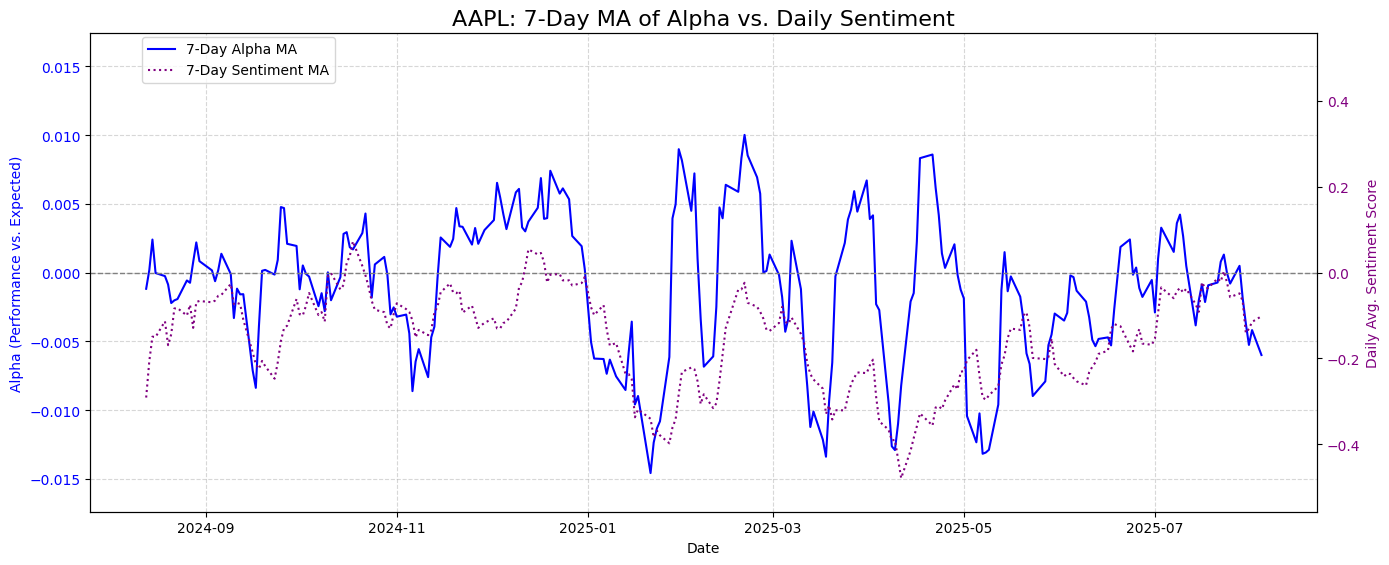

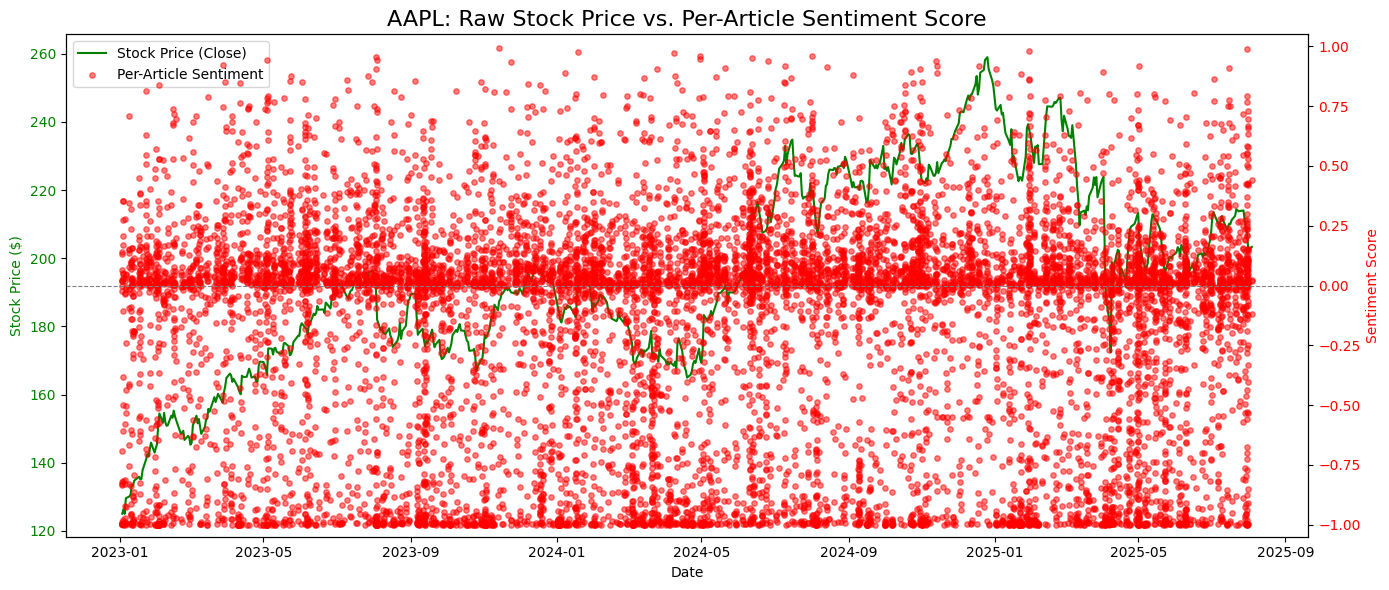

In [7]:
# ─── Cell 4: Plotting with Aligned & Synced Data ──────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR    = Path("sentiment_scores")
PRICE_DIR   = Path("stock_price")
CAPM_DIR    = Path("CAPM")
ROLLING_AVG = 7

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    # Automatically find all tickers based on the files in the CAPM directory
    TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
    print(f"Found all available tickers: {TICKERS}")
else:
    # Use the user-provided list of tickers
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
for ticker in TICKERS:
    try:
        # Load all necessary files for both plots
        daily_sent_df   = pd.read_csv(SENT_DIR / f"{ticker}_daily_scores.csv", parse_dates=["date"])
        article_sent_df = pd.read_csv(SENT_DIR / f"{ticker}_article_scores.csv", parse_dates=["date"])
        price_df        = pd.read_csv(PRICE_DIR / f"{ticker}_price.csv", parse_dates=["date"])
        capm_df         = pd.read_csv(CAPM_DIR / f"{ticker}_CAPM.csv", parse_dates=["date"])

    except FileNotFoundError as e:
        print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
        continue

    print(f"\n--- Generating plots for {ticker} ---")

    # ─── PLOT 1: ALPHA MA vs. DAILY SENTIMENT MA ──────────────────────────────
    # Merge the datasets required for the first plot
    df1 = pd.merge(price_df[['date']], daily_sent_df, on="date", how="inner")
    df1 = pd.merge(df1, capm_df, on="date", how="inner")

    # Sort by date and filter to the last 1 year
    df1 = df1.sort_values('date')
    last_date = df1['date'].max()
    one_year_ago = last_date - pd.DateOffset(years=1)
    df1 = df1[df1['date'] >= one_year_ago].copy()
    
    # Forward-fill any gaps (e.g., weekends, holidays)
    df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')

    # Calculate moving averages for full periods only (no min_periods)
    df1["sentiment_ma"] = df1["sentiment"].rolling(ROLLING_AVG).mean()
    df1["alpha_ma"]     = df1["alpha"].rolling(ROLLING_AVG).mean()

    # Drop rows where the moving average is not yet calculated (the first 6 days)
    df1.dropna(subset=['alpha_ma', 'sentiment_ma'], inplace=True)

    if not df1.empty:
        fig, ax1 = plt.subplots(figsize=(14, 6))
        plt.title(f"{ticker}: {ROLLING_AVG}-Day MA of Alpha vs. Daily Sentiment", fontsize=16)
        
        # Plot Alpha MA
        ax1.plot(df1["date"], df1["alpha_ma"], color="blue", label=f"{ROLLING_AVG}-Day Alpha MA")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Alpha (Performance vs. Expected)", color="blue")
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True, linestyle="--", alpha=0.5)
        ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
        
        # Create a second y-axis for sentiment
        ax2 = ax1.twinx()
        ax2.plot(df1["date"], df1["sentiment_ma"], color="purple", linestyle='dotted', label=f"{ROLLING_AVG}-Day Sentiment MA")
        ax2.set_ylabel("Daily Avg. Sentiment Score", color="purple")
        ax2.tick_params(axis='y', labelcolor='purple')
        
        # Symmetrically align the zero-lines for better comparison
        y1_min, y1_max = ax1.get_ylim(); y1_abs_max = max(abs(y1_min), abs(y1_max)) * 1.1; ax1.set_ylim(-y1_abs_max, y1_abs_max)
        y2_min, y2_max = ax2.get_ylim(); y2_abs_max = max(abs(y2_min), abs(y2_max)) * 1.1; ax2.set_ylim(-y2_abs_max, y2_abs_max)
        
        # Display legend and show plot
        fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print(f"Not enough data to generate Alpha vs. Sentiment plot for {ticker}.")


    # ─── PLOT 2: RAW PRICE vs. PER-ARTICLE SENTIMENT ──────────────────────────
    # Merge per-article sentiment with price data. Use an inner join to keep only matching dates.
    df2 = pd.merge(article_sent_df, price_df, on="date", how="inner").dropna()

    if not df2.empty:
        fig, ax1 = plt.subplots(figsize=(14, 6))
        plt.title(f"{ticker}: Raw Stock Price vs. Per-Article Sentiment Score", fontsize=16)

        # Plot 1: Raw Price
        ax1.plot(df2["date"], df2["close"], color="green", label="Stock Price (Close)")
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Stock Price ($)", color="green")
        ax1.tick_params(axis='y', labelcolor='green')
        
        # Plot 2: Per-Article Sentiment as a scatter plot on a second y-axis
        ax2 = ax1.twinx()
        # A scatter plot is used because there can be multiple articles (and scores) on the same day
        ax2.scatter(df2["date"], df2["sentiment"], color="red", label="Per-Article Sentiment", alpha=0.5, s=15) # s is marker size
        ax2.set_ylabel("Sentiment Score", color="red")
        ax2.tick_params(axis='y', labelcolor='red')
        # Set sentiment limits from -1 to 1, which is the natural range of the score
        ax2.set_ylim(-1.05, 1.05)
        ax2.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        
        # Create a combined legend for both axes
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, loc="upper left")
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No matching data found for Price vs. Per-Article plot for {ticker}.")



C:\Users\User\AppData\Local\Temp\ipykernel_16596\3242610148.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['sentiment', 'alpha']] = df[['sentiment', 'alpha']].fillna(method='ffill')



--- Generating plot for AAPL ---


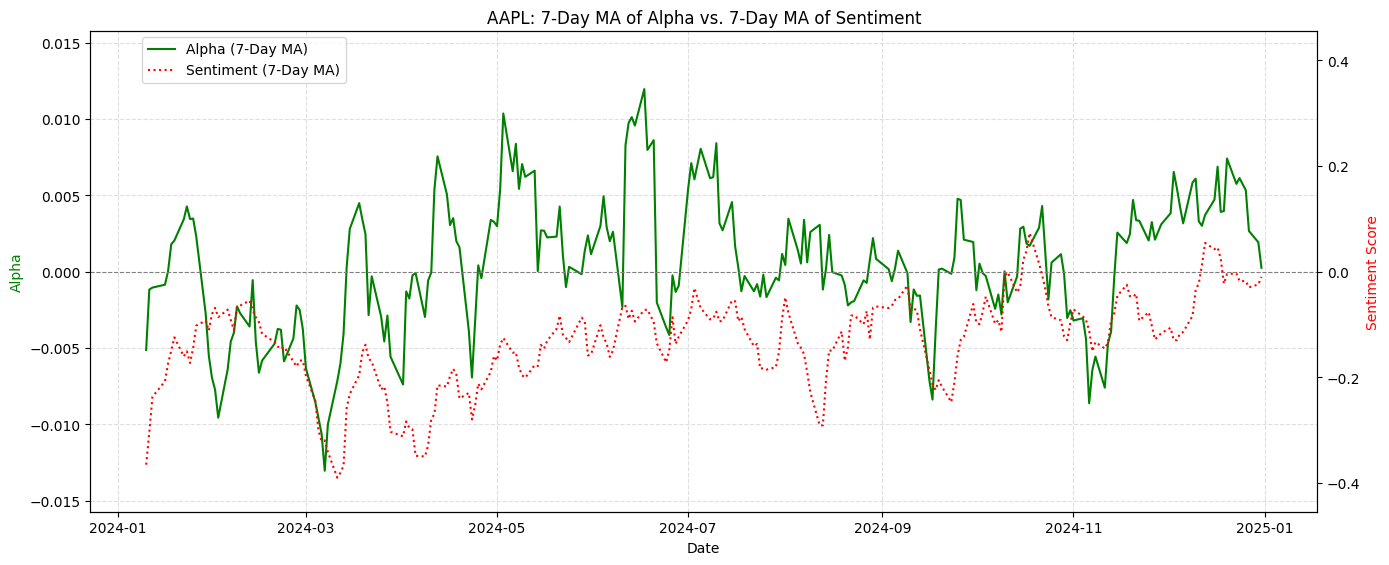

In [13]:
# ─── Cell 4: Plotting with Aligned & Synced Data ──────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR    = Path("sentiment_scores")
PRICE_DIR   = Path("stock_price")
CAPM_DIR    = Path("CAPM")
ROLLING_AVG = 7

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    # Automatically find all tickers based on the files in the CAPM directory
    TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
    print(f"Found all available tickers: {TICKERS}")
else:
    # Use the user-provided list of tickers
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    raise ValueError("No tickers specified.")

# ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
for ticker in TICKERS:
    try:
        # Load all necessary files
        sent_df  = pd.read_csv(SENT_DIR / f"{ticker}_daily_scores.csv", parse_dates=["date"])
        price_df = pd.read_csv(PRICE_DIR / f"{ticker}_price.csv", parse_dates=["date"])
        capm_df  = pd.read_csv(CAPM_DIR / f"{ticker}_CAPM.csv", parse_dates=["date"])
    except FileNotFoundError as e:
        print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
        continue

    # --- Data Processing ---
    # Merge all data sources using an 'inner' join to keep only dates present in all files.
    # This automatically syncs the start and end dates of all data series.
    df = pd.merge(price_df, sent_df, on="date", how="inner")
    df = pd.merge(df, capm_df, on="date", how="inner")

    # Filter data to the last 1 year, if data exists
    if not df.empty:
        df = df.sort_values('date')
        last_date = df['date'].max()
        one_year_ago = last_date - pd.DateOffset(years=1)
        df = df[df['date'] >= one_year_ago].copy()
    else:
        print(f"No overlapping data found for {ticker}. Skipping plot.")
        continue
    
    # Forward-fill is still useful for handling any minor, intermittent gaps (e.g., holidays)
    # within the 1-year window.
    df[['sentiment', 'alpha']] = df[['sentiment', 'alpha']].fillna(method='ffill')
    
    # Calculate moving averages for full 7-day periods only.
    # By omitting 'min_periods', the first 6 rows of the MA will be NaN.
    df["sentiment_ma"] = df["sentiment"].rolling(ROLLING_AVG).mean()
    df["alpha_ma"]     = df["alpha"].rolling(ROLLING_AVG).mean()

    # Drop rows where the moving average is not yet calculated.
    # This automatically trims the first 6 days from the dataset.
    df.dropna(subset=['alpha_ma', 'sentiment_ma'], inplace=True)

    if df.empty:
        print(f"Not enough data to generate plot for {ticker} after processing.")
        continue

    print(f"\n--- Generating plot for {ticker} ---")

    # --- Plotting ---
    dates = df["date"]
    fig, ax1 = plt.subplots(figsize=(14, 6))
    plt.title(f"{ticker}: {ROLLING_AVG}-Day MA of Alpha vs. {ROLLING_AVG}-Day MA of Sentiment")
    
    # Plot Alpha MA
    ax1.plot(dates, df["alpha_ma"], color="green", label=f"Alpha ({ROLLING_AVG}-Day MA)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Alpha", color="green")
    ax1.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax1.grid(True, linestyle="--", alpha=0.4)
    
    # Create a second y-axis for Sentiment MA
    ax2 = ax1.twinx()
    ax2.plot(dates, df["sentiment_ma"], color="red", linestyle='dotted', label=f"Sentiment ({ROLLING_AVG}-Day MA)")
    ax2.set_ylabel("Sentiment Score", color="red")
    
    # Symmetrically align the zero-lines of both axes for better visual comparison
    y1_min, y1_max = ax1.get_ylim()
    y1_abs_max = max(abs(y1_min), abs(y1_max)) * 1.1 # Add 10% padding
    ax1.set_ylim(-y1_abs_max, y1_abs_max)

    y2_min, y2_max = ax2.get_ylim()
    y2_abs_max = max(abs(y2_min), abs(y2_max)) * 1.1 # Add 10% padding
    ax2.set_ylim(-y2_abs_max, y2_abs_max)
    
    # Display legend and show the plot
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [12]:
# ─── Cell 4: Plotting with Aligned & Synced Data (Dark Theme) ─────────────────
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR        = Path("sentiment_scores")
PRICE_DIR       = Path("stock_price")
CAPM_DIR        = Path("CAPM")
ROLLING_AVG     = 7
CORR_WINDOW     = 30 # Window for the rolling correlation

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    # Automatically find all tickers based on the files in the CAPM directory
    try:
        TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
        if not TICKERS:
            print("No CAPM files found in the 'CAPM' directory.")
        else:
            print(f"Found all available tickers: {TICKERS}")
    except FileNotFoundError:
        print("Error: The 'CAPM' directory does not exist.")
        TICKERS = []
else:
    # Use the user-provided list of tickers
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    # Use a print statement instead of raising an error to avoid stopping execution
    print("No tickers were specified. Exiting script.")
else:
    # ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
    for ticker in TICKERS:
        try:
            # Load all necessary files
            daily_sent_df   = pd.read_csv(SENT_DIR / f"{ticker}_daily_scores.csv", parse_dates=["date"])
            article_sent_df = pd.read_csv(SENT_DIR / f"{ticker}_article_scores.csv", parse_dates=["date"])
            price_df        = pd.read_csv(PRICE_DIR / f"{ticker}_price.csv", parse_dates=["date"])
            capm_df         = pd.read_csv(CAPM_DIR / f"{ticker}_CAPM.csv", parse_dates=["date"])

        except FileNotFoundError as e:
            print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
            continue

        print(f"\n--- Generating plots for {ticker} ---")

        # ─── PLOT 1: ALPHA, SENTIMENT, AND ROLLING CORRELATION (INTERACTIVE) ─────
        df1 = pd.merge(price_df[['date']], daily_sent_df, on="date", how="inner")
        df1 = pd.merge(df1, capm_df, on="date", how="inner")
        df1 = df1.sort_values('date')
        # The one-year filter has been removed to show all available data.
        df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')
        df1["sentiment_ma"] = df1["sentiment"].rolling(ROLLING_AVG).mean()
        df1["alpha_ma"]     = df1["alpha"].rolling(ROLLING_AVG).mean()
        df1['rolling_corr'] = df1['alpha_ma'].rolling(CORR_WINDOW).corr(df1['sentiment_ma'])
        df1.dropna(subset=['alpha_ma', 'sentiment_ma', 'rolling_corr'], inplace=True)

        if not df1.empty:
            # Create figure with multiple y-axes
            fig = go.Figure()

            # Add Alpha MA Line (Primary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["alpha_ma"], 
                    name=f"{ROLLING_AVG}-Day Alpha MA",
                    line=dict(color="#3399FF")
                )
            )

            # Add Sentiment MA Line (Secondary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["sentiment_ma"], 
                    name=f"{ROLLING_AVG}-Day Sentiment MA",
                    line=dict(color="#FF33CC"),
                    yaxis="y2"
                )
            )
            
            # Add Correlation Line (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'],
                    name=f'{CORR_WINDOW}-Day Rolling Correlation',
                    line=dict(color="#00FF00"),
                    yaxis="y3"
                )
            )

            # --- Layout and Styling ---
            y1_max = df1['alpha_ma'].abs().max() * 1.1
            y2_max = df1['sentiment_ma'].abs().max() * 1.1

            fig.update_layout(
                title_text=f"{ticker}: Alpha, Sentiment, and {CORR_WINDOW}-Day Rolling Correlation",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(domain=[0, 0.85]), # Leave space on the right for axes
                
                # --- AXIS CONFIGURATION ---
                # Y-Axis 1 (Alpha) - Left
                yaxis=dict(
                    title="Alpha (Performance vs. Expected)",
                    titlefont=dict(color="#3399FF"),
                    tickfont=dict(color="#3399FF"),
                    range=[-y1_max, y1_max]
                ),
                
                # Y-Axis 2 (Sentiment) - Right
                yaxis2=dict(
                    title="Daily Avg. Sentiment Score",
                    titlefont=dict(color="#FF33CC"),
                    tickfont=dict(color="#FF33CC"),
                    anchor="x",
                    overlaying="y",
                    side="right",
                    range=[-y2_max, y2_max]
                ),

                # Y-Axis 3 (Correlation) - Far Right
                yaxis3=dict(
                    title="Rolling Correlation",
                    titlefont=dict(color="#00FF00"),
                    tickfont=dict(color="#00FF00"),
                    anchor="free",
                    overlaying="y",
                    side="right",
                    position=0.95, # Position it further to the right
                    range=[-1.05, 1.05],
                    showgrid=False
                )
            )
            # Add a zero line for the primary y-axis
            fig.add_shape(type="line", x0=df1.date.min(), y0=0, x1=df1.date.max(), y1=0,
                          line=dict(color="gray", width=1, dash="dash"), yref='y1')


            fig.show()
        else:
            print(f"Not enough data to generate Alpha vs. Sentiment plot for {ticker}.")


        # ─── PLOT 2: RAW PRICE vs. PER-ARTICLE SENTIMENT (INTERACTIVE) ───────────
        df2 = pd.merge(article_sent_df, price_df, on="date", how="inner").dropna()

        if not df2.empty:
            # Create figure with secondary y-axis
            fig = make_subplots(specs=[[{"secondary_y": True}]])

            # Add Price Line
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["close"], 
                    name="Stock Price (Close)",
                    line=dict(color="#00FF00")
                ),
                secondary_y=False,
            )

            # Add Per-Article Sentiment Scatter
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["sentiment"], 
                    name="Per-Article Sentiment",
                    mode='markers',
                    marker=dict(color="#FF5733", opacity=0.6, size=5)
                ),
                secondary_y=True,
            )

            # --- Layout and Styling ---
            fig.update_layout(
                title_text=f"{ticker}: Raw Stock Price vs. Per-Article Sentiment Score",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )

            # Set y-axes titles
            fig.update_yaxes(title_text="Stock Price ($)", color="#00FF00", secondary_y=False)
            fig.update_yaxes(title_text="Sentiment Score", color="#FF5733", range=[-1.05, 1.05], secondary_y=True)
            
            # Add a zero line for the sentiment y-axis
            fig.add_shape(type="line", x0=df2.date.min(), y0=0, x1=df2.date.max(), y1=0,
                          line=dict(color="gray", width=1, dash="dash"), yref='y2')

            fig.show()
        else:
            print(f"No matching data found for Price vs. Per-Article plot for {ticker}.")



--- Generating plots for AAPL ---


/var/folders/z1/mmvdtrkx5cj21fm_n8s5wyzr0000gn/T/ipykernel_8355/1098463299.py:55: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [10]:
# ─── Cell 4: Plotting with Aligned & Synced Data (Dark Theme) ─────────────────
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR        = Path("sentiment_scores")
PRICE_DIR       = Path("stock_price")
CAPM_DIR        = Path("CAPM")
ROLLING_AVG     = 7
CORR_WINDOW     = 30 # Window for the rolling correlation

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    # Automatically find all tickers based on the files in the CAPM directory
    try:
        TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
        if not TICKERS:
            print("No CAPM files found in the 'CAPM' directory.")
        else:
            print(f"Found all available tickers: {TICKERS}")
    except FileNotFoundError:
        print("Error: The 'CAPM' directory does not exist.")
        TICKERS = []
else:
    # Use the user-provided list of tickers
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    # Use a print statement instead of raising an error to avoid stopping execution
    print("No tickers were specified. Exiting script.")
else:
    # ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
    for ticker in TICKERS:
        try:
            # Load all necessary files
            daily_sent_df   = pd.read_csv(SENT_DIR / f"{ticker}_daily_scores.csv", parse_dates=["date"])
            article_sent_df = pd.read_csv(SENT_DIR / f"{ticker}_article_scores.csv", parse_dates=["date"])
            price_df        = pd.read_csv(PRICE_DIR / f"{ticker}_price.csv", parse_dates=["date"])
            capm_df         = pd.read_csv(CAPM_DIR / f"{ticker}_CAPM.csv", parse_dates=["date"])

        except FileNotFoundError as e:
            print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
            continue

        print(f"\n--- Generating plots for {ticker} ---")

        # ─── PLOT 1: ALPHA, SENTIMENT, AND ROLLING CORRELATION (INTERACTIVE) ─────
        df1 = pd.merge(price_df[['date']], daily_sent_df, on="date", how="inner")
        df1 = pd.merge(df1, capm_df, on="date", how="inner")
        df1 = df1.sort_values('date')
        last_date = df1['date'].max()
        one_year_ago = last_date - pd.DateOffset(years=2)
        df1 = df1[df1['date'] >= one_year_ago].copy()
        df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')
        df1["sentiment_ma"] = df1["sentiment"].rolling(ROLLING_AVG).mean()
        df1["alpha_ma"]     = df1["alpha"].rolling(ROLLING_AVG).mean()
        df1['rolling_corr'] = df1['alpha_ma'].rolling(CORR_WINDOW).corr(df1['sentiment_ma'])
        df1.dropna(subset=['alpha_ma', 'sentiment_ma', 'rolling_corr'], inplace=True)

        if not df1.empty:
            # Create figure with secondary y-axis
            fig = go.Figure()

            # Add Alpha MA Line (Primary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["alpha_ma"], 
                    name=f"{ROLLING_AVG}-Day Alpha MA",
                    line=dict(color="#1964EE")
                )
            )

            # Add Sentiment MA Line (Secondary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["sentiment_ma"], 
                    name=f"{ROLLING_AVG}-Day Sentiment MA",
                    line=dict(color="#F600BD"),
                    yaxis="y2"
                )
            )
            
            # Add Positive Correlation Shading (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'].where(df1['rolling_corr'] >= 0),
                    mode='lines',
                    line=dict(width=0),
                    fill='tozeroy',
                    fillcolor='rgba(8, 139, 80, 0.3)',
                    name=f'{CORR_WINDOW}-Day Positive Correlation',
                    hoverinfo='skip',
                    yaxis="y3"
                )
            )

            # Add Negative Correlation Shading (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'].where(df1['rolling_corr'] < 0),
                    mode='lines',
                    line=dict(width=0),
                    fill='tozeroy',
                    fillcolor='rgba(255, 0, 0, 0.3)',
                    name=f'{CORR_WINDOW}-Day Negative Correlation',
                    hoverinfo='skip',
                    yaxis="y3"
                )
            )
            
            # Add an invisible line for the correlation hover data (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'],
                    mode='lines',
                    line=dict(color='rgba(0,0,0,0)'),
                    name='Rolling Correlation',
                    hovertemplate='Date: %{x}<br>Correlation: %{y:.3f}<extra></extra>',
                    showlegend=False,
                    yaxis="y3"
                )
            )

            # --- Layout and Styling ---
            y1_max = df1['alpha_ma'].abs().max() * 1.1
            y2_max = df1['sentiment_ma'].abs().max() * 1.1

            fig.update_layout(
                title_text=f"{ticker}: Alpha, Sentiment, and {CORR_WINDOW}-Day Rolling Correlation",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(domain=[0, 0.85]), # Leave space on the right for axes
                
                # --- AXIS CONFIGURATION ---
                # Y-Axis 1 (Alpha) - Left
                yaxis=dict(
                    title="Alpha (Performance vs. Expected)",
                    titlefont=dict(color="#1964EE"),
                    tickfont=dict(color="#1964EE"),
                    range=[-y1_max, y1_max]
                ),
                
                # Y-Axis 2 (Sentiment) - Right
                yaxis2=dict(
                    title="Daily Avg. Sentiment Score",
                    titlefont=dict(color="#F600BD"),
                    tickfont=dict(color="#F600BD"),
                    anchor="x",
                    overlaying="y",
                    side="right",
                    range=[-y2_max, y2_max]
                ),

                # Y-Axis 3 (Correlation) - Far Right
                yaxis3=dict(
                    title="Rolling Correlation",
                    titlefont=dict(color="#00FF00"),
                    tickfont=dict(color="#00FF00"),
                    anchor="free",
                    overlaying="y",
                    side="right",
                    position=0.95, # Position it further to the right
                    range=[-1.05, 1.05],
                    showgrid=False,
                    zeroline=True,
                    zerolinewidth=1,
                    zerolinecolor='white'
                )
            )

            fig.show()
        else:
            print(f"Not enough data to generate Alpha vs. Sentiment plot for {ticker}.")


        # ─── PLOT 2: RAW PRICE vs. PER-ARTICLE SENTIMENT (INTERACTIVE) ───────────
        df2 = pd.merge(article_sent_df, price_df, on="date", how="inner").dropna()

        if not df2.empty:
            # Create figure with secondary y-axis
            fig = make_subplots(specs=[[{"secondary_y": True}]])

            # Add Price Line
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["close"], 
                    name="Stock Price (Close)",
                    line=dict(color="#00FF00")
                ),
                secondary_y=False,
            )

            # Add Per-Article Sentiment Scatter
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["sentiment"], 
                    name="Per-Article Sentiment",
                    mode='markers',
                    marker=dict(color="#FF5733", opacity=0.6, size=5)
                ),
                secondary_y=True,
            )

            # --- Layout and Styling ---
            fig.update_layout(
                title_text=f"{ticker}: Raw Stock Price vs. Per-Article Sentiment Score",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )

            # Set y-axes titles
            fig.update_yaxes(title_text="Stock Price ($)", color="#00FF00", secondary_y=False)
            fig.update_yaxes(title_text="Sentiment Score", color="#FF5733", range=[-1.05, 1.05], secondary_y=True)

            fig.show()
        else:
            print(f"No matching data found for Price vs. Per-Article plot for {ticker}.")



--- Generating plots for AAPL ---


/var/folders/z1/mmvdtrkx5cj21fm_n8s5wyzr0000gn/T/ipykernel_8355/2060226025.py:57: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [4]:
# ─── Cell 4: Plotting with Aligned & Synced Data (Dark Theme) ─────────────────
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR        = Path("sentiment_scores")
PRICE_DIR       = Path("stock_price")
CAPM_DIR        = Path("CAPM")
ROLLING_AVG     = 7
CORR_WINDOW     = 30 # Window for the rolling correlation

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    # Automatically find all tickers based on the files in the CAPM directory
    try:
        TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
        if not TICKERS:
            print("No CAPM files found in the 'CAPM' directory.")
        else:
            print(f"Found all available tickers: {TICKERS}")
    except FileNotFoundError:
        print("Error: The 'CAPM' directory does not exist.")
        TICKERS = []
else:
    # Use the user-provided list of tickers
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    # Use a print statement instead of raising an error to avoid stopping execution
    print("No tickers were specified. Exiting script.")
else:
    # ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
    for ticker in TICKERS:
        try:
            # Load all necessary files
            daily_sent_df   = pd.read_csv(SENT_DIR / f"{ticker}_daily_scores.csv", parse_dates=["date"])
            article_sent_df = pd.read_csv(SENT_DIR / f"{ticker}_article_scores.csv", parse_dates=["date"])
            price_df        = pd.read_csv(PRICE_DIR / f"{ticker}_price.csv", parse_dates=["date"])
            capm_df         = pd.read_csv(CAPM_DIR / f"{ticker}_CAPM.csv", parse_dates=["date"])

        except FileNotFoundError as e:
            print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
            continue

        print(f"\n--- Generating plots for {ticker} ---")

        # ─── PLOT 1: ALPHA, SENTIMENT, AND ROLLING CORRELATION (INTERACTIVE) ─────
        df1 = pd.merge(price_df[['date']], daily_sent_df, on="date", how="inner")
        df1 = pd.merge(df1, capm_df, on="date", how="inner")
        df1 = df1.sort_values('date')
        last_date = df1['date'].max()
        one_year_ago = last_date - pd.DateOffset(years=1)
        df1 = df1[df1['date'] >= one_year_ago].copy()
        df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')
        df1["sentiment_ma"] = df1["sentiment"].rolling(ROLLING_AVG).mean()
        df1["alpha_ma"]     = df1["alpha"].rolling(ROLLING_AVG).mean()
        df1['rolling_corr'] = df1['alpha_ma'].rolling(CORR_WINDOW).corr(df1['sentiment_ma'])
        df1.dropna(subset=['alpha_ma', 'sentiment_ma', 'rolling_corr'], inplace=True)

        if not df1.empty:
            # Create figure with secondary y-axis
            fig = go.Figure()

            # Add Alpha MA Line (Primary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["alpha_ma"], 
                    name=f"{ROLLING_AVG}-Day Alpha MA",
                    line=dict(color="#1964EE")
                )
            )

            # Add Sentiment MA Line (Secondary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["sentiment_ma"], 
                    name=f"{ROLLING_AVG}-Day Sentiment MA",
                    line=dict(color="#F600BD"),
                    yaxis="y2"
                )
            )
            
            # Add Positive Correlation Shading (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'].where(df1['rolling_corr'] >= 0),
                    mode='lines',
                    line=dict(width=0),
                    fill='tozeroy',
                    fillcolor='rgba(8, 139, 80, 0.3)',
                    name=f'{CORR_WINDOW}-Day Positive Correlation',
                    hoverinfo='skip',
                    yaxis="y3"
                )
            )

            # Add Negative Correlation Shading (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'].where(df1['rolling_corr'] < 0),
                    mode='lines',
                    line=dict(width=0),
                    fill='tozeroy',
                    fillcolor='rgba(255, 0, 0, 0.3)',
                    name=f'{CORR_WINDOW}-Day Negative Correlation',
                    hoverinfo='skip',
                    yaxis="y3"
                )
            )
            
            # Add an invisible line for the correlation hover data (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'],
                    mode='lines',
                    line=dict(color='rgba(0,0,0,0)'),
                    name='Rolling Correlation',
                    hovertemplate='Date: %{x}<br>Correlation: %{y:.3f}<extra></extra>',
                    showlegend=False,
                    yaxis="y3"
                )
            )

            # --- Layout and Styling ---
            y1_max = df1['alpha_ma'].abs().max() * 1.1
            y2_max = df1['sentiment_ma'].abs().max() * 1.1

            fig.update_layout(
                title_text=f"{ticker}: Alpha, Sentiment, and {CORR_WINDOW}-Day Rolling Correlation",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(domain=[0, 0.85]), # Leave space on the right for axes
                
                # --- AXIS CONFIGURATION ---
                # Y-Axis 1 (Alpha) - Left
                yaxis=dict(
                    title="Alpha (Performance vs. Expected)",
                    titlefont=dict(color="#1964EE"),
                    tickfont=dict(color="#1964EE"),
                    range=[-y1_max, y1_max]
                ),
                
                # Y-Axis 2 (Sentiment) - Right
                yaxis2=dict(
                    title="Daily Avg. Sentiment Score",
                    titlefont=dict(color="#F600BD"),
                    tickfont=dict(color="#F600BD"),
                    anchor="x",
                    overlaying="y",
                    side="right",
                    range=[-y2_max, y2_max]
                ),

                # Y-Axis 3 (Correlation) - Far Right
                yaxis3=dict(
                    title="Rolling Correlation",
                    titlefont=dict(color="#00FF00"),
                    tickfont=dict(color="#00FF00"),
                    anchor="free",
                    overlaying="y",
                    side="right",
                    position=0.95, # Position it further to the right
                    range=[-1.05, 1.05],
                    showgrid=False,
                    zeroline=True,
                    zerolinewidth=1,
                    zerolinecolor='white'
                )
            )

            fig.show()
        else:
            print(f"Not enough data to generate Alpha vs. Sentiment plot for {ticker}.")


        # ─── PLOT 2: RAW PRICE vs. PER-ARTICLE SENTIMENT (INTERACTIVE) ───────────
        df2 = pd.merge(article_sent_df, price_df, on="date", how="inner").dropna()

        if not df2.empty:
            # Create figure with secondary y-axis
            fig = make_subplots(specs=[[{"secondary_y": True}]])

            # Add Price Line
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["close"], 
                    name="Stock Price (Close)",
                    line=dict(color="#00FF00")
                ),
                secondary_y=False,
            )

            # Add Per-Article Sentiment Scatter
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["sentiment"], 
                    name="Per-Article Sentiment",
                    mode='markers',
                    marker=dict(color="#FF5733", opacity=0.6, size=5)
                ),
                secondary_y=True,
            )

            # --- Layout and Styling ---
            fig.update_layout(
                title_text=f"{ticker}: Raw Stock Price vs. Per-Article Sentiment Score",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )

            # Set y-axes titles
            fig.update_yaxes(title_text="Stock Price ($)", color="#00FF00", secondary_y=False)
            fig.update_yaxes(title_text="Sentiment Score", color="#FF5733", range=[-1.05, 1.05], secondary_y=True)

            fig.show()
        else:
            print(f"No matching data found for Price vs. Per-Article plot for {ticker}.")



--- Generating plots for AAPL ---


/var/folders/z1/mmvdtrkx5cj21fm_n8s5wyzr0000gn/T/ipykernel_8355/2312313984.py:57: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [8]:
# ─── Cell 4: Plotting with Aligned & Synced Data (Dark Theme) ─────────────────
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ─── CONFIG ───────────────────────────────────────────────────────────────────
SENT_DIR        = Path("sentiment_scores")
PRICE_DIR       = Path("stock_price")
CAPM_DIR        = Path("CAPM")
ROLLING_AVG     = 7
CORR_WINDOW     = 30 # Window for the rolling correlation

# ─── USER INPUT ───────────────────────────────────────────────────────────────
tickers_input = input("Enter tickers (e.g. AAPL,MSFT) or 'ALL' for all from CAPM folder: ")
if tickers_input.strip().upper() == 'ALL':
    # Automatically find all tickers based on the files in the CAPM directory
    try:
        TICKERS = [p.stem.replace("_CAPM", "") for p in CAPM_DIR.glob("*.csv")]
        if not TICKERS:
            print("No CAPM files found in the 'CAPM' directory.")
        else:
            print(f"Found all available tickers: {TICKERS}")
    except FileNotFoundError:
        print("Error: The 'CAPM' directory does not exist.")
        TICKERS = []
else:
    # Use the user-provided list of tickers
    TICKERS = [t.strip().upper() for t in tickers_input.split(",") if t.strip()]

if not TICKERS:
    # Use a print statement instead of raising an error to avoid stopping execution
    print("No tickers were specified. Exiting script.")
else:
    # ─── GENERATE PLOTS ───────────────────────────────────────────────────────────
    for ticker in TICKERS:
        try:
            # Load all necessary files
            daily_sent_df   = pd.read_csv(SENT_DIR / f"{ticker}_daily_scores.csv", parse_dates=["date"])
            article_sent_df = pd.read_csv(SENT_DIR / f"{ticker}_article_scores.csv", parse_dates=["date"])
            price_df        = pd.read_csv(PRICE_DIR / f"{ticker}_price.csv", parse_dates=["date"])
            capm_df         = pd.read_csv(CAPM_DIR / f"{ticker}_CAPM.csv", parse_dates=["date"])

        except FileNotFoundError as e:
            print(f"Could not find a required file for {ticker}: {e}. Skipping plots.")
            continue

        print(f"\n--- Generating plots for {ticker} ---")

        # ─── PLOT 1: ALPHA, SENTIMENT, AND ROLLING CORRELATION (INTERACTIVE) ─────
        df1 = pd.merge(price_df[['date']], daily_sent_df, on="date", how="inner")
        df1 = pd.merge(df1, capm_df, on="date", how="inner")
        df1 = df1.sort_values('date')
        # The one-year filter has been removed to show all available data.
        df1[['sentiment', 'alpha']] = df1[['sentiment', 'alpha']].fillna(method='ffill')
        df1["sentiment_ma"] = df1["sentiment"].rolling(ROLLING_AVG).mean()
        df1["alpha_ma"]     = df1["alpha"].rolling(ROLLING_AVG).mean()
        df1['rolling_corr'] = df1['alpha_ma'].rolling(CORR_WINDOW).corr(df1['sentiment_ma'])
        df1.dropna(subset=['alpha_ma', 'sentiment_ma', 'rolling_corr'], inplace=True)

        if not df1.empty:
            # Create figure with multiple y-axes
            fig = go.Figure()

            # Add Alpha MA Line (Primary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["alpha_ma"], 
                    name=f"{ROLLING_AVG}-Day Alpha MA",
                    line=dict(color="#1964EE")
                )
            )

            # Add Sentiment MA Line (Secondary Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1["date"], 
                    y=df1["sentiment_ma"], 
                    name=f"{ROLLING_AVG}-Day Sentiment MA",
                    line=dict(color="#F600BD"),
                    yaxis="y2"
                )
            )
            
            # Add Positive Correlation Shading (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'].where(df1['rolling_corr'] >= 0),
                    mode='lines',
                    line=dict(width=0),
                    fill='tozeroy',
                    fillcolor='rgba(8, 139, 80, 0.3)',
                    name=f'{CORR_WINDOW}-Day Positive Correlation',
                    hoverinfo='skip',
                    yaxis="y3"
                )
            )

            # Add Negative Correlation Shading (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'].where(df1['rolling_corr'] < 0),
                    mode='lines',
                    line=dict(width=0),
                    fill='tozeroy',
                    fillcolor='rgba(255, 0, 0, 0.3)',
                    name=f'{CORR_WINDOW}-Day Negative Correlation',
                    hoverinfo='skip',
                    yaxis="y3"
                )
            )
            
            # Add an invisible line for the correlation hover data (Third Y-axis)
            fig.add_trace(
                go.Scatter(
                    x=df1['date'],
                    y=df1['rolling_corr'],
                    mode='lines',
                    line=dict(color='rgba(0,0,0,0)'),
                    name='Rolling Correlation',
                    hovertemplate='Date: %{x}<br>Correlation: %{y:.3f}<extra></extra>',
                    showlegend=False,
                    yaxis="y3"
                )
            )

            # --- Layout and Styling ---
            y1_max = df1['alpha_ma'].abs().max() * 1.1
            y2_max = df1['sentiment_ma'].abs().max() * 1.1

            fig.update_layout(
                title_text=f"{ticker}: Alpha, Sentiment, and {CORR_WINDOW}-Day Rolling Correlation",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(domain=[0, 0.85]), # Leave space on the right for axes
                
                # --- AXIS CONFIGURATION ---
                # Y-Axis 1 (Alpha) - Left
                yaxis=dict(
                    title="Alpha (Performance vs. Expected)",
                    titlefont=dict(color="#1964EE"),
                    tickfont=dict(color="#1964EE"),
                    range=[-y1_max, y1_max]
                ),
                
                # Y-Axis 2 (Sentiment) - Right
                yaxis2=dict(
                    title="Daily Avg. Sentiment Score",
                    titlefont=dict(color="#F600BD"),
                    tickfont=dict(color="#F600BD"),
                    anchor="x",
                    overlaying="y",
                    side="right",
                    range=[-y2_max, y2_max]
                ),

                # Y-Axis 3 (Correlation) - Far Right
                yaxis3=dict(
                    title="Rolling Correlation",
                    titlefont=dict(color="#00FF00"),
                    tickfont=dict(color="#00FF00"),
                    anchor="free",
                    overlaying="y",
                    side="right",
                    position=0.95, # Position it further to the right
                    range=[-1.05, 1.05],
                    showgrid=False,
                    zeroline=True,
                    zerolinewidth=1,
                    zerolinecolor='white'
                )
            )

            fig.show()
        else:
            print(f"Not enough data to generate Alpha vs. Sentiment plot for {ticker}.")


        # ─── PLOT 2: RAW PRICE vs. PER-ARTICLE SENTIMENT (INTERACTIVE) ───────────
        df2 = pd.merge(article_sent_df, price_df, on="date", how="inner").dropna()

        if not df2.empty:
            # Create figure with secondary y-axis
            fig = make_subplots(specs=[[{"secondary_y": True}]])

            # Add Price Line
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["close"], 
                    name="Stock Price (Close)",
                    line=dict(color="#00FF00")
                ),
                secondary_y=False,
            )

            # Add Per-Article Sentiment Scatter
            fig.add_trace(
                go.Scatter(
                    x=df2["date"], 
                    y=df2["sentiment"], 
                    name="Per-Article Sentiment",
                    mode='markers',
                    marker=dict(color="#FF5733", opacity=0.6, size=5)
                ),
                secondary_y=True,
            )

            # --- Layout and Styling ---
            fig.update_layout(
                title_text=f"{ticker}: Raw Stock Price vs. Per-Article Sentiment Score",
                template="plotly_dark",
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
            )

            # Set y-axes titles
            fig.update_yaxes(title_text="Stock Price ($)", color="#00FF00", secondary_y=False)
            fig.update_yaxes(title_text="Sentiment Score", color="#FF5733", range=[-1.05, 1.05], secondary_y=True)

            fig.show()
        else:
            print(f"No matching data found for Price vs. Per-Article plot for {ticker}.")



--- Generating plots for AAPL ---


/var/folders/z1/mmvdtrkx5cj21fm_n8s5wyzr0000gn/T/ipykernel_8355/2172278175.py:55: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

